# Decomposed Time Series

***

Decompose a time series as:

y(t) = ybar + ytrend(t) + yvar(t)

where 

- ybar is the mean value over all time and/or time-varying (monthly or seasonally)

- ytrend(t) is the long-term change over the full record. Modeled as a linear trend in this notebook.

- yvar is the variability or anomalies. This consists of the variations of y about the mean and trend. 

In [189]:
import numpy as np 
import cmocean
from netCDF4 import Dataset
import glob
import matplotlib.pyplot as plt
import datetime 
from datetime import date 
import mpl_toolkits.basemap as bm
import matplotlib.animation as animation
import numpy.ma as ma
import matplotlib.cm as cm
from matplotlib.patches import Polygon
from scipy import signal
import time
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings; warnings.simplefilter('ignore')
# %matplotlib notebook

In [2]:
# Load data for reduced domain

path = '/extra-space1/data/tikoralukupload/cis-weekly/nc/'

# Hudson Bay region
nc = Dataset(path + 'HB.nc', 'r')
lon = nc.variables['longitude'][600:1450,1700:]
lat = nc.variables['latitude'][600:1450,1700:]
land = nc.variables['land'][600:1450,1700:]
juld = nc.variables['juld'][:]
E_CT = nc.variables['E_CT'][:,600:1450,1700:]
E_FA = nc.variables['E_FA'][:,600:1450,1700:]
E_SA = nc.variables['E_SA'][:,600:1450,1700:]
nc.close()

### Calculate the trends

In [6]:
# Mean of entire time series
ybar = np.nanmean(E_CT, axis=0)

# Subtract the mean from the time series
dCT = E_CT - ybar

The following cell calculates the trend along the time axis for each spatial coordinate. I initially tried using scipy.signal.detrend as it is extremely fast (~10 seconds to calculate the trends for the entire HB domain), but there were issues with some data being thrown away and the results were inconsistent with np.polyfit, for reasons I cannot explain. Using np.polyfit for the selected domain is slower, but not painfully slow. 163 seconds for 810900 time steps!

In [7]:
tic = time.time()

n = 850 # shape of lon
m = 954

ytrend=np.zeros((n,m))

# Calculate trends along time axis
for i in range(n):
    for j in range(m):
        z = np.polyfit(juld, dCT[:,i,j], 1)
        ytrend[i,j] = z[0] 
        
toc = time.time()
print(toc-tic)

163.91443395614624


### Map the trends

vmin and vmax are chosen qualitatively, by looking at the map without bounds and then choosing the limits so that they are centered about 0.

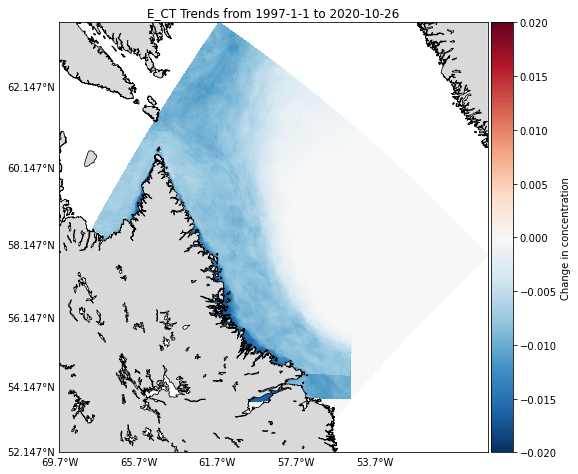

In [299]:
# Map trends
fig = plt.figure(figsize=(9,9))
ax = fig.add_axes([0.1, 0.1, 0.7, 0.75])

domain = [99, 99, -99, -99]
domain[0] = np.min(lat) # South
domain[2] = np.max(lat) # North
domain[1] = np.min(lon) # West
domain[3] = np.max(lon) # East
# domain = list(np.array(domain) + np.array([+6, +3, -5, -9]))
proj = bm.Basemap(projection='merc', llcrnrlat=domain[0], llcrnrlon=domain[1], urcrnrlat=domain[2], urcrnrlon=domain[3], resolution='h')
lonproj, latproj = proj(lon, lat)
proj.fillcontinents(color='0.85', lake_color=None, ax=None, zorder=None, alpha=None)
proj.drawcoastlines(color='k', linewidth=0.75)

# Add ticks
parallels = np.arange(domain[0],domain[2],2.)
# labels = [left,right,top,bottom]
proj.drawparallels(parallels,labels=[True,False,True,False], linewidth=0)
# meridians = np.arange(domain[1],domain[3],2.)
meridians = np.arange(-69.7, -49.7, 4.)
proj.drawmeridians(meridians,labels=[True,False,False,True],linewidth=0)

inds = np.array(months)==1
im = plt.pcolormesh(lonproj,latproj,ytrend,cmap='RdBu_r',vmin=-0.02, vmax=0.02)

plt.title('E_CT Trends from 1997-1-1 to 2020-10-26')
ax = plt.gca()

# Fix colorbar axis
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, cax=cax)
cbar.set_label('Change in concentration')


The units of above are suspect. Since concentration is 0-11, they are not actually expressed in tenths (concentration). 

### Monthly mean and trends

Needs work: my organization of dates.

In [269]:
# Convert dates
d0ord = date(1950,1,1).toordinal()
dt_ordinal = d0ord + juld

dates = [date.fromordinal(dt_ordinal[tt]) for tt in range(len(juld))]
years = [dates[tt].year for tt in range(len(juld))]
months = [dates[tt].month for tt in range(len(juld))]
days = [dates[tt].day for tt in range(len(juld))]

months_unique = np.unique(months)
# Mask out land
E_CT = np.ma.filled(E_CT.astype(float), np.nan)

# Calculate monthly means and subtract them from time series
ybar_monthly=[]
dCT_monthly=[]
month_occurences=[]
for month in months_unique:
    inds = np.array(months)==month
    # Monthly means
    ybar_monthly.append(np.nanmean(E_CT[inds,:,:],axis=0))
    # Subtract mean from time series
    dCT_monthly.append(E_CT[inds,:,:] - np.nanmean(E_CT[inds,:,:],axis=0))
    # Indices of dates within each month
    month_occurences.append(juld[inds])
    
ybar_monthly = np.array(ybar_monthly)

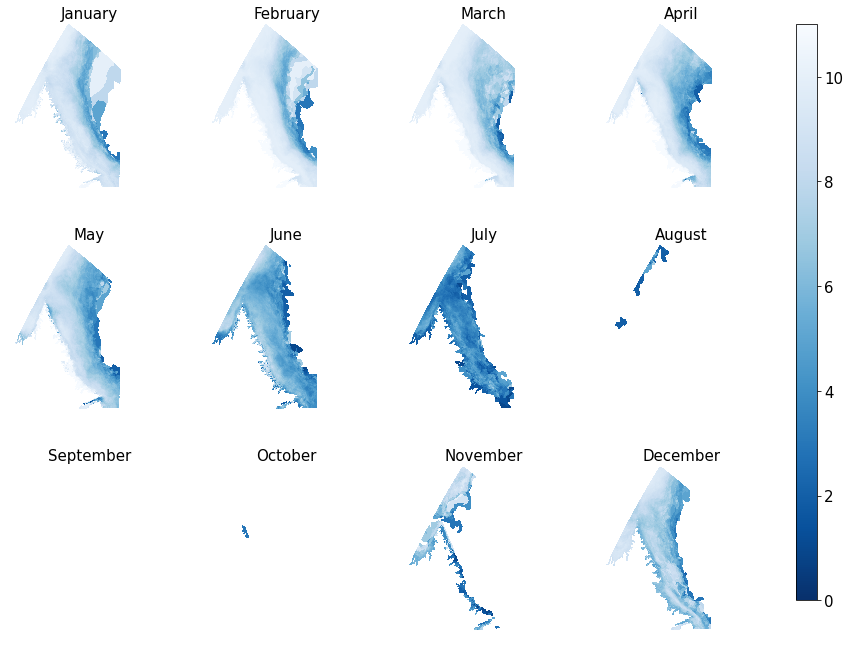

In [240]:
# Map monthly means
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))

months_str = ['January','February','March','April','May','June','July',
             'August','September','October','November','December']
cnt = 0
for ax in axes.flat:
    ax.set_axis_off()
    ax.set_title(months_str[cnt], fontsize=15)
    im = ax.pcolormesh(lonproj,latproj,ybar_monthly[cnt,:,:],cmap='Blues_r',vmin=0,vmax=11)   
    cnt +=1
    
fig.subplots_adjust(bottom=0.03, top=0.9, left=0.1, right=0.8,
                    wspace=0.2, hspace=0.2)

cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax)
cbar.ax.tick_params(labelsize=15)

In [241]:
tic = time.time()

n = 850 # shape of lon
m = 954

ytrend_monthly=np.zeros((12,n,m))

for month in range(0,12):
    for i in range(n):
        for j in range(m):
        # Don't run polyfit on nans 
            idx = np.isfinite(month_occurences[month]) & np.isfinite(dCT_monthly[month][:,i,j])
            if idx.any()==True:
                z = np.polyfit(month_occurences[month][idx], dCT_monthly[month][:,i,j][idx], 1)
                ytrend_monthly[month,i,j] = z[0] 
        
toc = time.time()
print(toc-tic)

1732.0282912254333


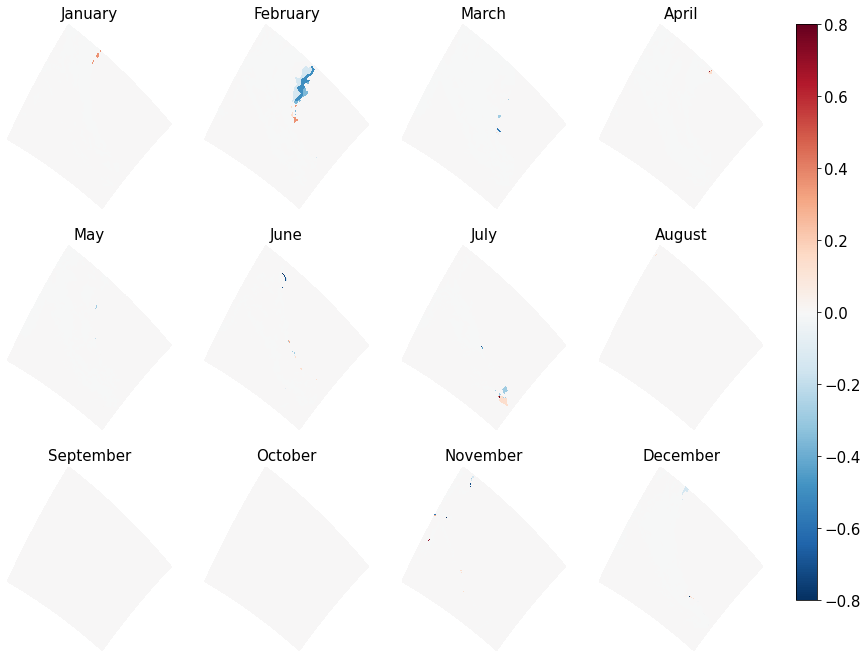

In [302]:
# Map monthly trends
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))

months_str = ['January','February','March','April','May','June','July',
             'August','September','October','November','December']
cnt = 0
for ax in axes.flat:
    ax.set_axis_off()
    ax.set_title(months_str[cnt], fontsize=15)
    im = ax.pcolormesh(lonproj,latproj,ytrend_monthly[cnt,:,:],cmap='RdBu_r',vmin=-0.8,vmax=0.8)   
    cnt +=1
    
fig.subplots_adjust(bottom=0.03, top=0.9, left=0.1, right=0.8,
                    wspace=0.2, hspace=0.2)

cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax)
cbar.ax.tick_params(labelsize=15)

What?? I expected more colours on these maps... grey (0 value) implies that there are no (or very little) changes in concentration year to year. But we saw from the first figure that over the entire time series there is a net negative trend over (almost) the entire domain. Removing the bounds allows us to visualize the small changes, but I'm not sure how to interpret the plots:

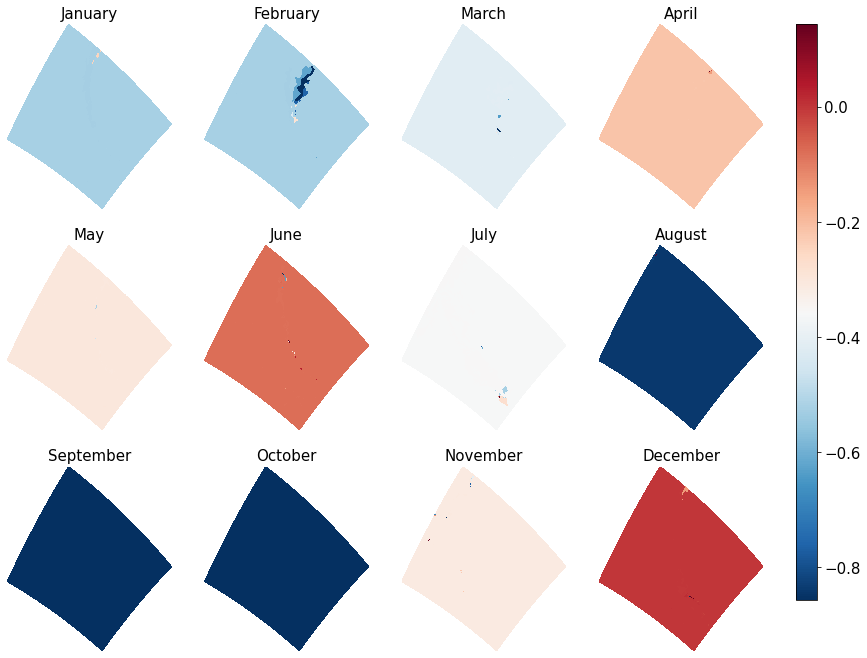

In [303]:
# Map monthly trends WITHOUT limits
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))

months_str = ['January','February','March','April','May','June','July',
             'August','September','October','November','December']
cnt = 0
for ax in axes.flat:
    ax.set_axis_off()
    ax.set_title(months_str[cnt], fontsize=15)
    im = ax.pcolormesh(lonproj,latproj,ytrend_monthly[cnt,:,:],cmap='RdBu_r')   
    cnt +=1
    
fig.subplots_adjust(bottom=0.03, top=0.9, left=0.1, right=0.8,
                    wspace=0.2, hspace=0.2)

cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax)
cbar.ax.tick_params(labelsize=15)

Not sure what's going on here. Why are Aug/Sept/Oct not 0?

### Plot anomolies


In [227]:
# Subtract ytrend from the time series
yvar_monthly = []
for i in range(len(ytrend_monthly)):
    yvar_monthly.append(dCT_monthly[i] - ytrend_monthly[i,:,:])

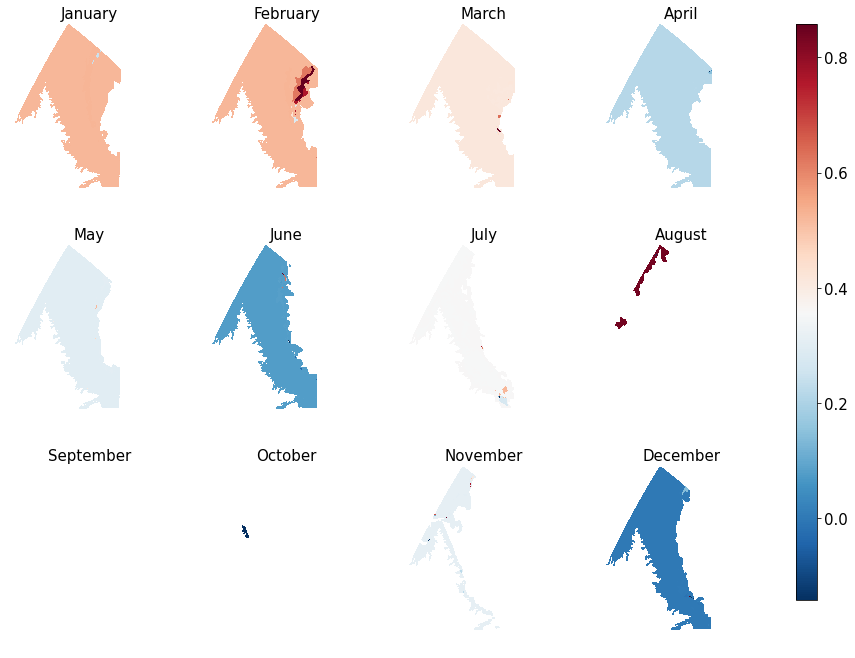

In [290]:
# Plot the anomolies
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))

cnt = 0
for ax in axes.flat:
    ax.set_axis_off()
    ax.set_title(months_str[cnt], fontsize=15)
    # Take average of anomolies
    im = ax.pcolormesh(lonproj,latproj,np.nanmean(yvar_monthly[cnt],axis=0),cmap='RdBu_r')   
    cnt +=1
    
fig.subplots_adjust(bottom=0.03, top=0.9, left=0.1, right=0.8,
                    wspace=0.2, hspace=0.2)

cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax)
cbar.ax.tick_params(labelsize=15)

Variability is pretty large although mean is very small for most months. For instance (January): 

In [295]:
np.nanmin(yvar_monthly[0])

-8.457020829925618

In [296]:
np.nanmax(yvar_monthly[0])

5.820301345137057

If I add limits in the pcolormesh function it's really hard to see the differences between months, so I've ommitted them above.

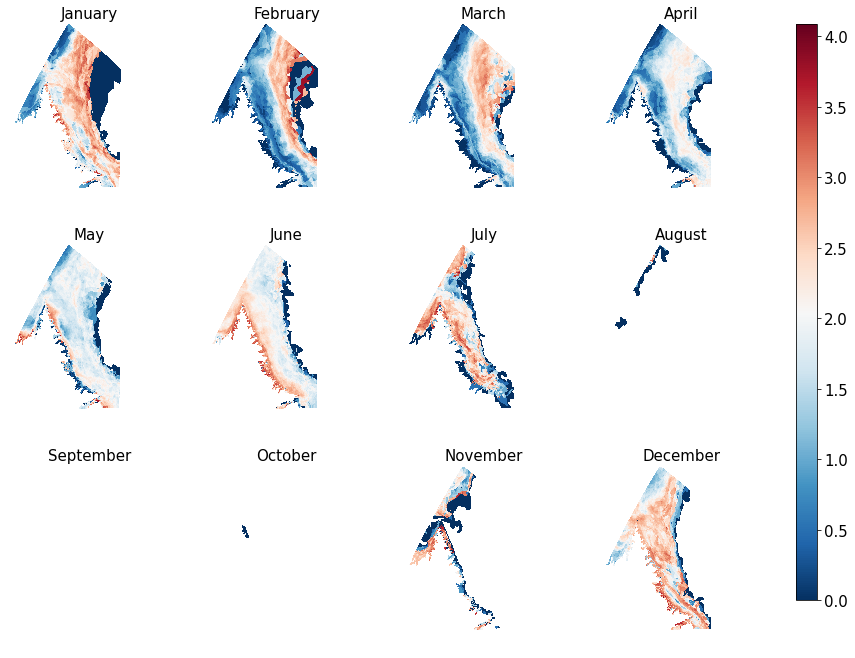

In [305]:
# Standard deviation of anomolies

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))

cnt = 0
for ax in axes.flat:
    yvar_std = np.nanstd(yvar_monthly[cnt],axis=0)
    ax.set_axis_off()
    ax.set_title(months_str[cnt], fontsize=15)
    im = ax.pcolormesh(lonproj,latproj,yvar_std,cmap='RdBu_r')   
    cnt +=1
    
fig.subplots_adjust(bottom=0.03, top=0.9, left=0.1, right=0.8,
                    wspace=0.2, hspace=0.2)

cb_ax = fig.add_axes([0.83, 0.1, 0.02, 0.8])
cbar = fig.colorbar(im, cax=cb_ax)
cbar.ax.tick_params(labelsize=15)

Interesting! Larger anomolies away from the coastline in peak ice months. (Expected? Sea ice extent is decreasing...) 